## Particle Collision

Simple example: 
9 particles at the begining.

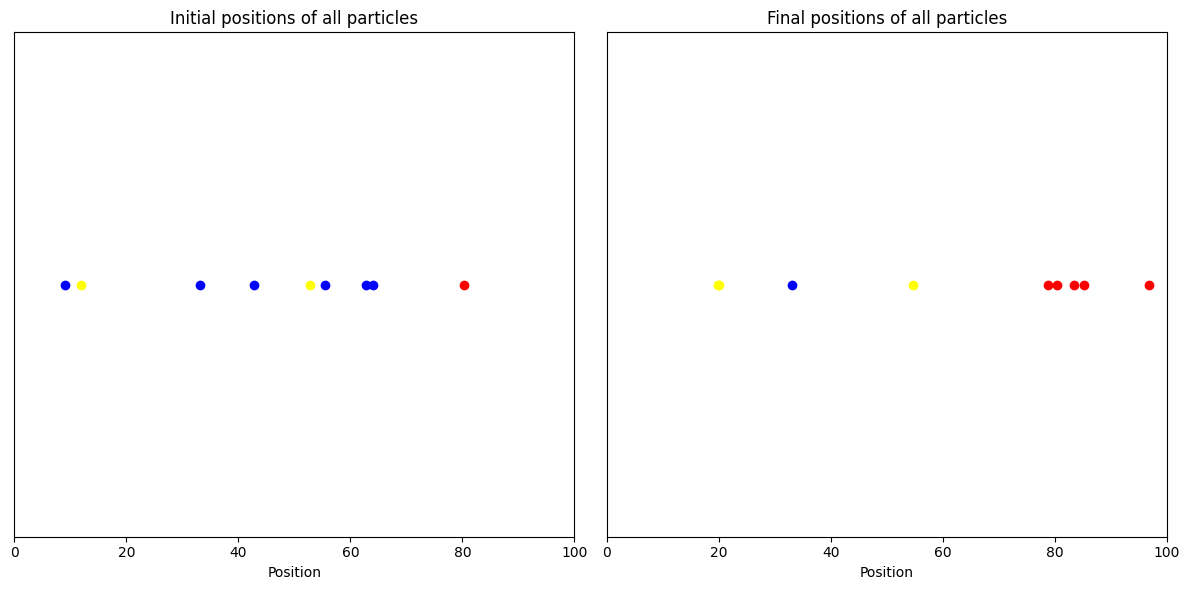

Final particle counts by type: [5 3 1]
Color red,yellow, and blue represent particle A,B and C respectively.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=999)
def simulate_particles(num_particles, space_range=100, radius=2, time_steps=1000, speed=2):
    num_types = len(num_particles)  # 粒子类型数量
    total_particles = sum(num_particles)  # 总粒子数
    positions = np.random.rand(total_particles) * space_range  # 初始化粒子位置
    particle_types = np.concatenate([np.full(n, i) for i, n in enumerate(num_particles)])  # 初始化粒子类型
    
    # 准备绘制
    plt.figure(figsize=(12, 6))
    colors = ['red', 'yellow', 'blue']  # 为每种类型分配颜色
    type_labels = ['A', 'B', 'C']  # 类型标签
    
    # 绘制初始状态
    plt.subplot(1, 2, 1)
    for i in range(total_particles):
        plt.scatter(positions[i], 0, c=colors[int(particle_types[i])])
    plt.title('Initial positions of all particles')
    plt.xlabel('Position')
    plt.yticks([])
    plt.xlim(0, space_range)
    
    # 模拟粒子运动
    for _ in range(time_steps):
        directions = np.random.choice([-speed, speed], size=total_particles)
        positions += directions
        
        # 边界处理
        for i in range(total_particles):
            if positions[i] < 0 or positions[i] > space_range:
                directions[i] = -directions[i]  # 反向移动
                positions[i] += 2 * directions[i]  # 再次更新位置
        
        # 碰撞检测和处理
        for i in range(total_particles):
            for j in range(i + 1, total_particles):
                if abs(positions[i] - positions[j]) <= 2 * radius and particle_types[i] != particle_types[j]:
                    # 找到未参与碰撞的第三种类型
                    third_type = 3 - particle_types[i] - particle_types[j]
                    particle_types[i], particle_types[j] = third_type, third_type
                    break
    
    # 绘制最终状态
    plt.subplot(1, 2, 2)
    for i in range(total_particles):
        plt.scatter(positions[i], 0, c=colors[int(particle_types[i])])
    plt.title('Final positions of all particles')
    plt.xlabel('Position')
    plt.yticks([])
    plt.xlim(0, space_range)
    
    plt.tight_layout()
    plt.show()
    
    # 计算并返回最终每种类型粒子的数量
    final_counts = np.bincount(particle_types.astype(int), minlength=num_types)
    return final_counts

# 示例调用
num_particles = [1,2,6]  # 每种类型粒子的数量
final_counts = simulate_particles(num_particles=num_particles)
print("Final particle counts by type:", final_counts)
print("Color red,yellow, and blue represent particle A,B and C respectively.")


# Attack
## Setup

### Define Particles
It includes:
- Position
- Velocity
- Particle type
- Radius

In [2]:
class Particle:
    def __init__(self, position, velocity, particle_type, radius):
        self.position = np.array(position) 
        self.velocity = np.array(velocity)  
        self.type = particle_type
        self.radius = radius

    def update_position(self, dt):
        self.position += self.velocity * dt

In [3]:

def initialize_particles(particles_info, box_size, velocity_scale):
    """
    初始化粒子，允许每种粒子有不同的数量和半径。

    :param particles_info: 一个字典，键是粒子类型，值是一个包含数量和半径的元组。
    :param box_size: 盒子的大小，是一个三元组（length, width, height）
    :param velocity_scale: 速度的比例系数，用于控制粒子速度的大小
    :return: 粒子对象列表
    """
    particles = []
    for particle_type, (num, radius) in particles_info.items():
        for _ in range(num):
            position = np.random.rand(3) * box_size  # 随机初始位置
            velocity = (np.random.rand(3) - 0.5) * velocity_scale  # 随机初始速度
            particles.append(Particle(position, velocity, particle_type, radius))
    return particles


In [169]:
#Print out each particles
#for i, particle in enumerate(particles):
#    print(f"Particle {i}: Type={particle.type}, Position={particle.position}, Velocity={particle.velocity}, Radius={particle.radius}")


## Define Collision 

In [46]:
def calculate_distance(particle1, particle2):
    return np.linalg.norm(particle1.position - particle2.position)
#Detect which particles have collided.
def detect_collisions(particles):
    collisions = []
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            if calculate_distance(particles[i], particles[j]) < (particles[i].radius + particles[j].radius):
                collisions.append((i, j))
    return collisions
# A,B collides then they all becomes C


def handle_boundary_collision(particle, box_size):
    # box_size 是一个三元组 (length, width, height)
    for i in range(3):  # 对于 x, y, z 分量
        if particle.position[i] < 0 or particle.position[i] > box_size[i]:
            particle.velocity[i] = -particle.velocity[i]  

            
            
def update_particles(particles, box_size, dt, velocity_scale):
    for particle in particles:
        particle.update_position(dt)
        handle_boundary_collision(particle, box_size)
    # 检测并处理碰撞
    collisions = detect_collisions(particles)
    for i, j in collisions:
        # 碰撞处理函数现在也需要 velocity_scale 参数
        handle_collision(particles[i], particles[j], velocity_scale)



def randomize_velocity(particle, velocity_scale):
    
    random_direction = np.random.rand(3) - 0.5
    unit_vector = random_direction / np.linalg.norm(random_direction)
    particle.velocity = unit_vector * velocity_scale

def handle_collision(particle1, particle2, velocity_scale):
    if particle1.type != particle2.type:
        type_set = {'A', 'B', 'C'}
        type_set.discard(particle1.type)
        type_set.discard(particle2.type) 
        new_type = type_set.pop()
        particle1.type = new_type
        particle2.type = new_type
        randomize_velocity(particle1, np.linalg.norm(particle1.velocity))
        randomize_velocity(particle2, np.linalg.norm(particle2.velocity))

In [187]:
def simulate(particles, box_size, steps, dt, velocity_scale):
    
    initial_types = [particle.type for particle in particles]
    initial_counts = Counter(initial_types)
    time_series_counts = {particle_type: [count] for particle_type, count in initial_counts.items()}
        
    for _ in range(steps):
        
        update_particles(particles, box_size, dt=0.01, velocity_scale=1)
        current_counts = Counter([p.type for p in particles])
        
        for type in ['A', 'B', 'C']:
            time_series_counts[type].append(current_counts.get(type, 0))
        
    final_positions = [particle.position for particle in particles]
    return final_positions, time_series_counts


In [223]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_positions(initial_positions, initial_types, final_positions, final_types, radius_map):
    fig = plt.figure(figsize=(14, 7))
    color_map = {'A': 'y', 'B': 'r', 'C': 'b'}  # 为每种类型指定颜色
    marker_map = {'A': 'o', 'B': '^', 'C': 's'}  # 为每种类型指定形状

    # 绘制初始位置
    ax1 = fig.add_subplot(121, projection='3d')
    for particle_type, color in color_map.items():
        indices = [i for i, t in enumerate(initial_types) if t == particle_type]
        sizes = [radius_map[particle_type]*10 for i in indices]  # 根据半径调整点的大小
        ax1.scatter(initial_positions[indices, 0], initial_positions[indices, 1], initial_positions[indices, 2], c=color, s=sizes, label=particle_type, marker=marker_map[particle_type])
    ax1.set_title('Initial Positions')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()

    # 绘制最终位置
    ax2 = fig.add_subplot(122, projection='3d')
    for particle_type, color in color_map.items():
        indices = [i for i, t in enumerate(final_types) if t == particle_type]
        sizes = [radius_map[particle_type]*10 for i in indices]  # 根据半径调整点的大小
        ax2.scatter(final_positions[indices, 0], final_positions[indices, 1], final_positions[indices, 2], c=color, s=sizes, label=particle_type, marker=marker_map[particle_type])
    ax2.set_title('Final Positions')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.legend()

    plt.show()


On the below function, everything needed are written inside.
The input is particle_info, box_size, velocity_scale, steps, dt, repeat_times

In [235]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def run_simulation(particles_info, box_size, velocity_scale, steps, dt, repeat_times,radius_map):
    
    particles = initialize_particles(particles_info, box_size, velocity_scale)
    initial_types = [particle.type for particle in particles]
    initial_positions = np.array([particle.position for particle in particles])
    
    simulation_results = simulate(particles, box_size, steps, dt, velocity_scale)
    final_positions = np.array(simulation_results[0])
    final_types = [particle.type for particle in particles]  # 模拟后粒子的最终类型
    time_series_counts = simulation_results[1]

    #plot initial position and final position
    plot_positions(initial_positions, initial_types, final_positions, final_types,radius_map)

    # plot time series
    plt.figure(figsize=(10, 6))
    time_steps = range(len(next(iter(time_series_counts.values()))))
    for particle_type, counts in time_series_counts.items():
        plt.plot(time_steps, counts, label=f'Type {particle_type}')
    plt.xlabel('Time Step')
    plt.ylabel('Particle Count')
    plt.title('Particle Counts Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # repeat experiment
    final_counts_list = []
    for _ in range(repeat_times):
        particles1 = initialize_particles(particles_info, box_size, velocity_scale)
        simulate(particles1, box_size, steps, dt, velocity_scale)
        final_types = [particle.type for particle in particles1]
        final_counts_list.append(Counter(final_types))

    # mean and std
    average_counts = {type: np.mean([counts[type] for counts in final_counts_list]) for type in ['A', 'B', 'C']}
    stddev_counts = {type: np.std([counts[type] for counts in final_counts_list], ddof=1) for type in ['A', 'B', 'C']}

    return {
        'initial_counts': Counter(initial_types),
        'final_counts': Counter(final_types),
        'average_counts': average_counts,
        'stddev_counts': stddev_counts,
        'time_series_counts': time_series_counts
    }




## Baseline

- $numinit(P_A)=numinit(P_B)=numinit(P_C)= 100$
- $r(P_A)=r(P_B)=r(P_C)= 1$
- box size = 10x10x10
- velocity scale = 1
- dt = 0.1

In [ ]:
# 使用示例
particles_info = {
    'A': (100, 1.0),  # A类型粒子，半径1
    'B': (100, 1.0),  # B类型粒子，半径1
    'C': (100, 1.0),  # C类型粒子，半径1
}

box_size = np.array([10, 10, 10])  # 盒子大小
velocity_scale = 1  # 速度比例系数
steps = 100  # 时间步数
dt = 0.1  # 时间步长
repeat_times = 10  # 重复实验次数

# 运行模拟并获取结果
results = run_simulation(particles_info, box_size, velocity_scale, steps, dt, repeat_times)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])


## 2. Different initial number of particles

2a
- $numinit(P_A)= 240, numinit(P_B)=numinit(P_C)= 30$
- $r(P_A)=r(P_B)=r(P_C)= 1$
- box size = 10x10x10
- velocity scale = 1
- dt = 0.1


In [251]:
# 使用示例
particles_info1 = {
    'A': (240, 0.1),  # A类型粒子，半径1
    'B': (30, 0.5),  # B类型粒子，半径1
    'C': (30, ),  # C类型粒子，半径1
}

box_size = np.array([10, 10, 10])  # 盒子大小
velocity_scale = 1  # 速度比例系数
steps = 100  # 时间步数
dt = 0.1  # 时间步长
repeat_times = 10  # 重复实验次数

# 运行模拟并获取结果
results2a = run_simulation(particles_info1, box_size, velocity_scale, steps, dt, repeat_times)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

TypeError: run_simulation() missing 1 required positional argument: 'radius_map'

2b
- $numinit(P_A)= 180, numinit(P_B)=numinit(P_C)= 60$
- $r(P_A)=r(P_B)=r(P_C)= 1$
- box size = 10x10x10
- velocity scale = 1

In [197]:
particles_info2 = {
    'A': (180, 1.0),  # A类型粒子，半径1
    'B': (60, 1.0),  # B类型粒子，半径1
    'C': (60, 1.0),  # C类型粒子，半径1
}
results2b = run_simulation(particles_info2, box_size, velocity_scale, steps, dt, repeat_times)

KeyboardInterrupt: 

## 3. Different stepsize

3a
- $numinit(P_A)=numinit(P_B)=numinit(P_C)= 100$
- $r(P_A)=r(P_B)=r(P_C)= 1$
- box size = 10x10x10
- velocity scale = 1
- dt = 0.01

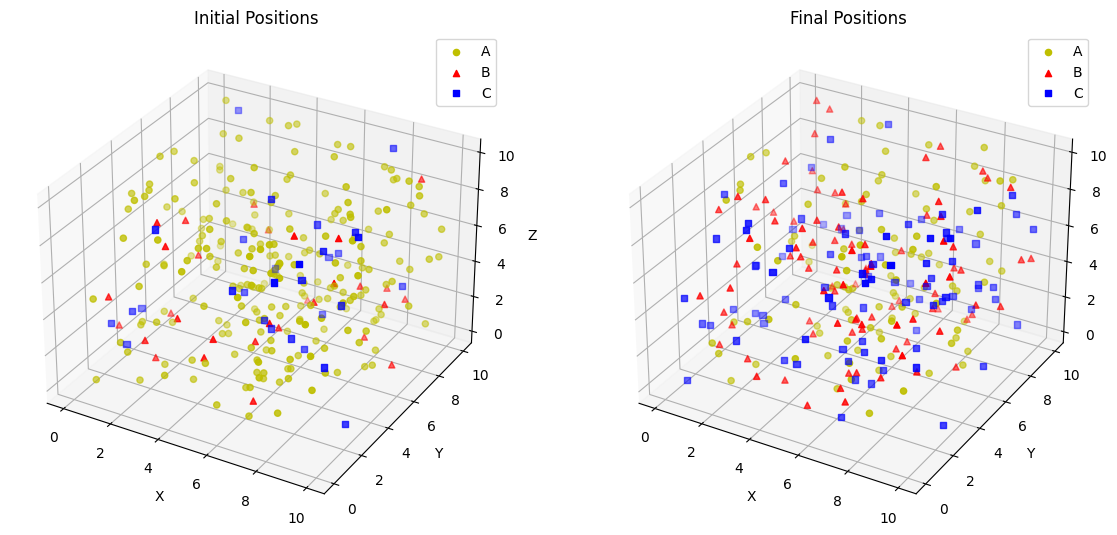

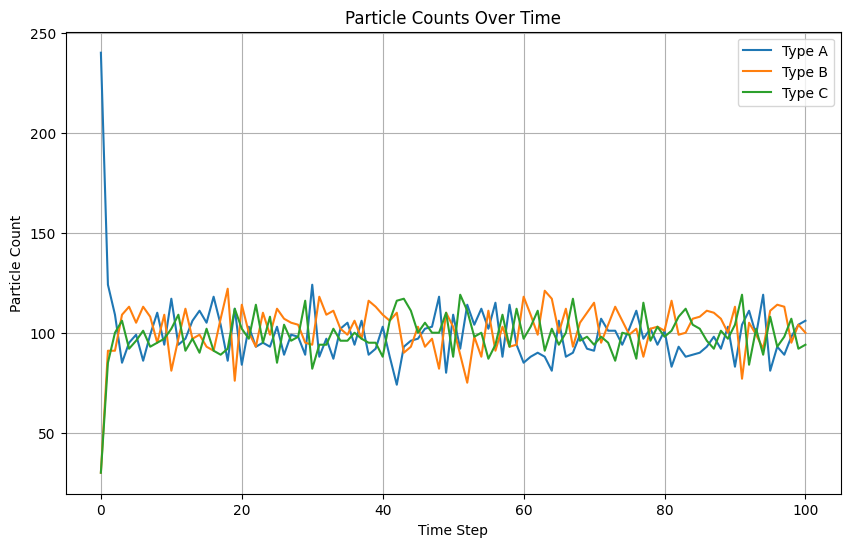

Initial particle counts: Counter({'A': 100, 'B': 100, 'C': 100})
Final particle counts: Counter({'A': 106, 'C': 100, 'B': 94})
Average counts: {'A': 100.1, 'B': 97.7, 'C': 102.2}
Standard deviations: {'A': 8.5693251387337, 'B': 8.538149682454625, 'C': 9.114091653404998}


In [200]:
# 使用示例
#use baseline particle "particles_info"
# use previous box_size 10x10x10
# velocity_scale = 1  # 速度比例系数
steps = 100  # 时间步数
dt_1 = 1  # 时间步长
#repeat_times = 10  # 重复实验次数
box_size1 = np.array([10, 10, 10])
# 运行模拟并获取结果
results3a = run_simulation(particles_info1, box_size1, velocity_scale, steps, dt_1, repeat_times)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

3b
- $numinit(P_A)=numinit(P_B)=numinit(P_C)= 100$
- $r(P_A)=r(P_B)=r(P_C)= 1$
- box size = 10x10x10
- velocity scale = 1
- dt = 0.001

In [ ]:
# 使用示例
#use baseline particle "particles_info"
# use previous box_size 10x10x10
# velocity_scale = 1  # 速度比例系数
# steps = 100  # 时间步数
dt_2 = 0.001  # 时间步长
#repeat_times = 10  # 重复实验次数

# 运行模拟并获取结果
results3b = run_simulation(particles_info, box_size, velocity_scale, steps, dt_2, repeat_times)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

3c
- $numinit(P_A)=numinit(P_B)=numinit(P_C)= 100$
- $r(P_A)=r(P_B)=r(P_C)= 1$
- box size = 10x10x10
- velocity scale = 1
- dt = 1

In [ ]:
# 使用示例
#use baseline particle "particles_info"
# use previous box_size 10x10x10
# velocity_scale = 1  # 速度比例系数
# steps = 100  # 时间步数
dt_3 = 1  # 时间步长
#repeat_times = 10  # 重复实验次数

# 运行模拟并获取结果
results3c = run_simulation(particles_info, box_size, velocity_scale, steps, dt_3, repeat_times)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

## 4. Different radius

4a
- $numinit(P_A)= 240,numinit(P_B)=numinit(P_C)= 30$
- $r(P_A)=r(P_B)=r(P_C)= 0.1$
- box size = 10x10x10
- velocity scale = 1
- dt = 0.01

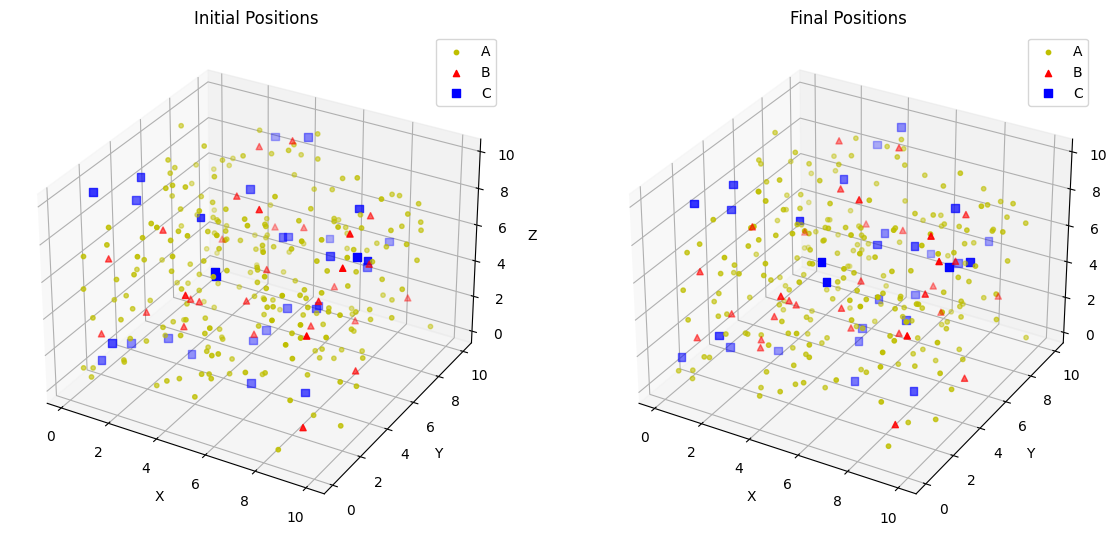

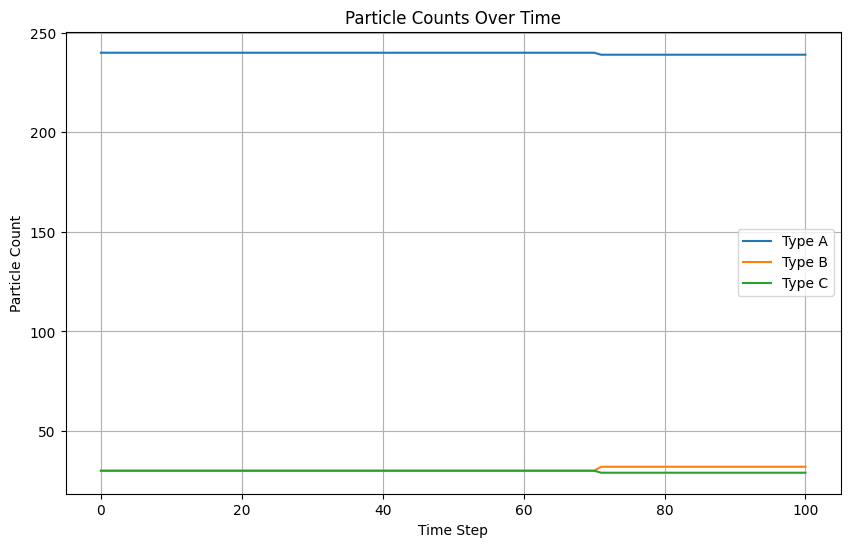

Initial particle counts: Counter({'A': 100, 'B': 100, 'C': 100})
Final particle counts: Counter({'A': 106, 'C': 100, 'B': 94})
Average counts: {'A': 100.1, 'B': 97.7, 'C': 102.2}
Standard deviations: {'A': 8.5693251387337, 'B': 8.538149682454625, 'C': 9.114091653404998}


In [230]:
# 即使radius小，导致他们在原来的基础上更难collides，但可以通过增加速度，stepsize来让他最终还是到达equilibrium
particles_info2 = {
    'A': (240, 0.1),  # A类型粒子，半径1
    'B': (30, 0.1),  # B类型粒子，半径1
    'C': (30, 0.1),  # C类型粒子，半径1
}

box_size = np.array([10, 10, 10])  # 盒子大小
velocity_scale = 1  # 速度比例系数
steps = 100  # 时间步数
dt = 0.1  # 时间步长
repeat_times = 10  # 重复实验次数
radius_map = {'A': 1, 'B': 2, 'C': 3}  # 假设半径大小

# 运行模拟并获取结果
results4a = run_simulation(particles_info2, box_size, velocity_scale, steps, dt, repeat_times,radius_map)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

4b

- $numinit(P_A)= 240,numinit(P_B)=numinit(P_C)= 30$
- $r(P_A)=r(P_B)=r(P_C)= 0.5$
- box size = 10x10x10
- velocity scale = 1
- dt = 0.01

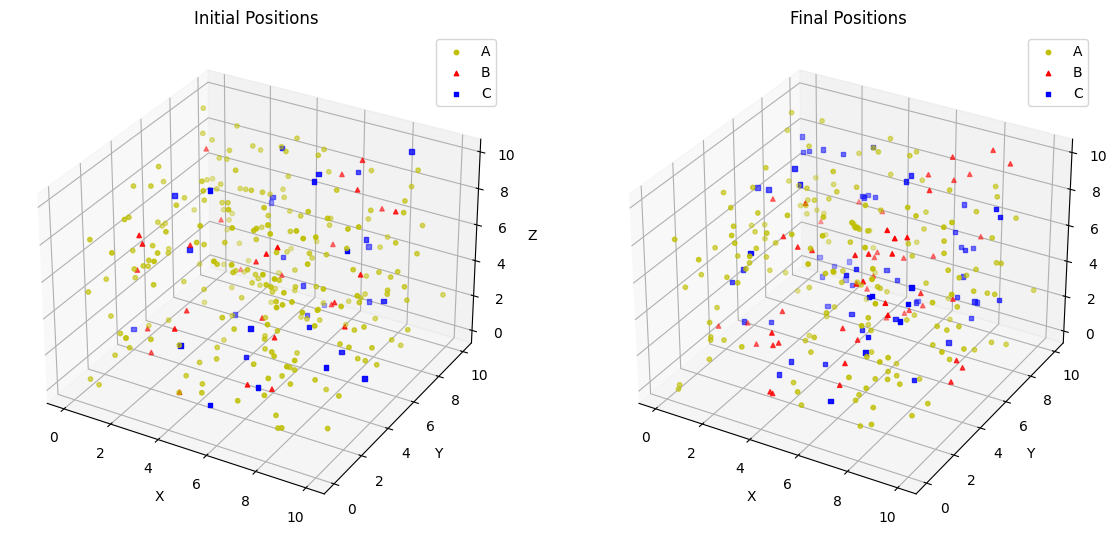

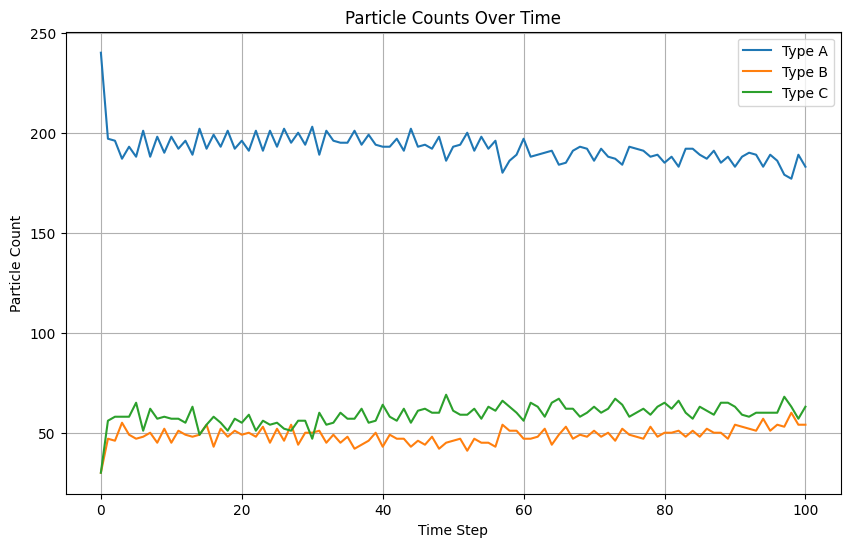

Initial particle counts: Counter({'A': 100, 'B': 100, 'C': 100})
Final particle counts: Counter({'A': 106, 'C': 100, 'B': 94})
Average counts: {'A': 100.1, 'B': 97.7, 'C': 102.2}
Standard deviations: {'A': 8.5693251387337, 'B': 8.538149682454625, 'C': 9.114091653404998}


In [236]:
# 即使radius小，导致他们在原来的基础上更难collides，但可以通过增加速度，stepsize来让他最终还是到达equilibrium
particles_info3 = {
    'A': (240, 0.5),  # A类型粒子，半径1
    'B': (30, 0.5),  # B类型粒子，半径1
    'C': (30, 0.5),  # C类型粒子，半径1
}

box_size = np.array([10, 10, 10])  # 盒子大小
velocity_scale = 1  # 速度比例系数
steps = 100  # 时间步数
dt = 0.1  # 时间步长
repeat_times = 10  # 重复实验次数
radius_map = {'A': 1, 'B': 1, 'C': 1}  # 假设半径大小

# 运行模拟并获取结果
results4a = run_simulation(particles_info3, box_size, velocity_scale, steps, dt, repeat_times,radius_map)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

## 5.Velocity

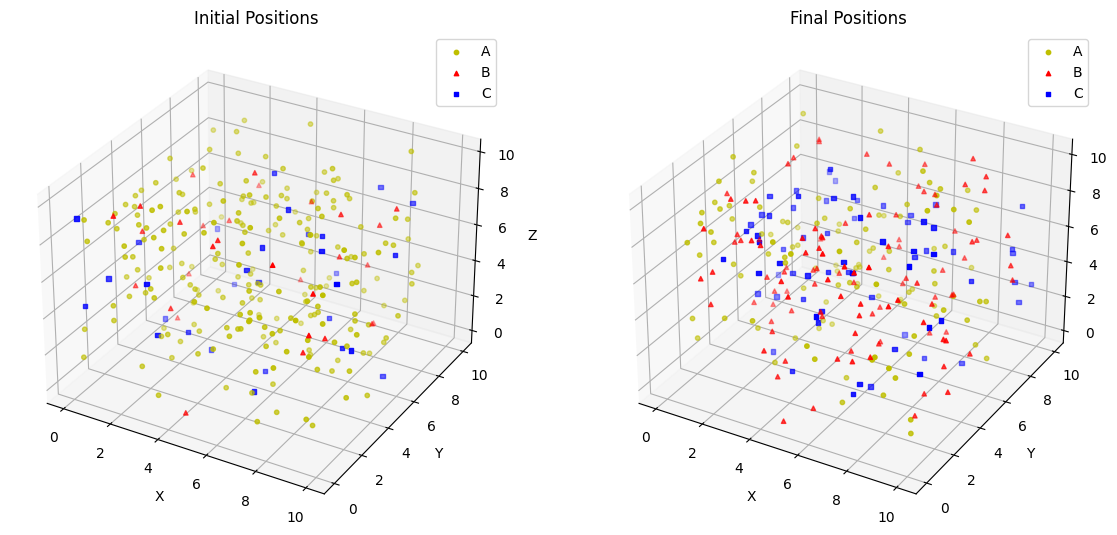

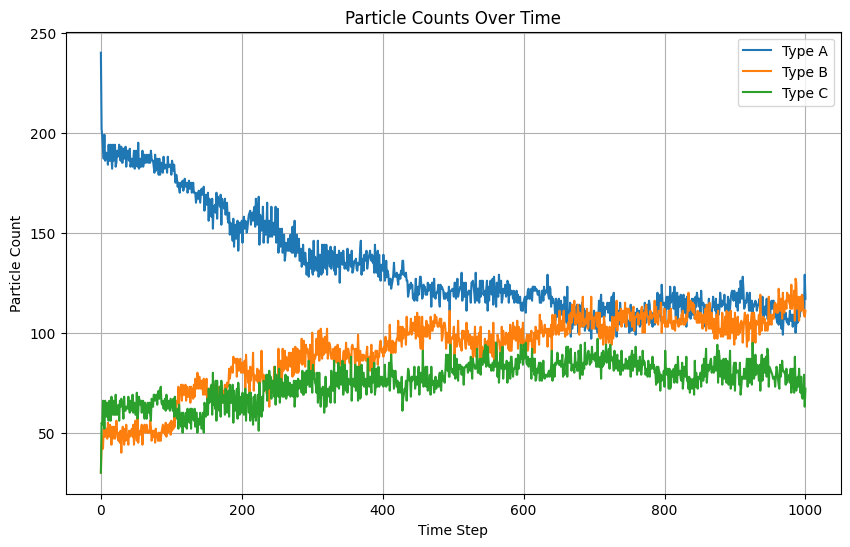

Initial particle counts: Counter({'A': 100, 'B': 100, 'C': 100})
Final particle counts: Counter({'A': 106, 'C': 100, 'B': 94})
Average counts: {'A': 100.1, 'B': 97.7, 'C': 102.2}
Standard deviations: {'A': 8.5693251387337, 'B': 8.538149682454625, 'C': 9.114091653404998}


In [246]:
# 即使radius小，导致他们在原来的基础上更难collides，但可以通过增加速度，stepsize来让他最终还是到达equilibrium
particles_info3 = {
    'A': (240, 0.5),  # A类型粒子，半径1
    'B': (30, 0.5),  # B类型粒子，半径1
    'C': (30, 0.5),  # C类型粒子，半径1
}

#box_size = np.array([10, 10, 10])  # 盒子大小
velocity_scale = 1  # 速度比例系数
steps1 = 1000  # 时间步数
#dt = 0.1  # 时间步长
#repeat_times = 10  # 重复实验次数
radius_map = {'A': 1, 'B': 1, 'C': 1}  # 假设半径大小

# 运行模拟并获取结果
results5a = run_simulation(particles_info3, box_size, velocity_scale, steps1, dt, repeat_times,radius_map)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

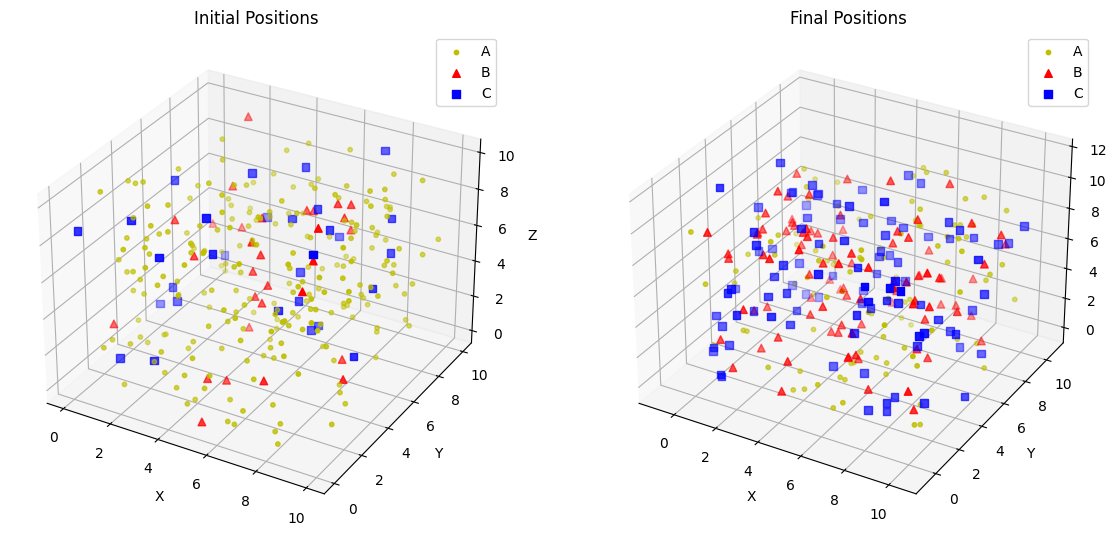

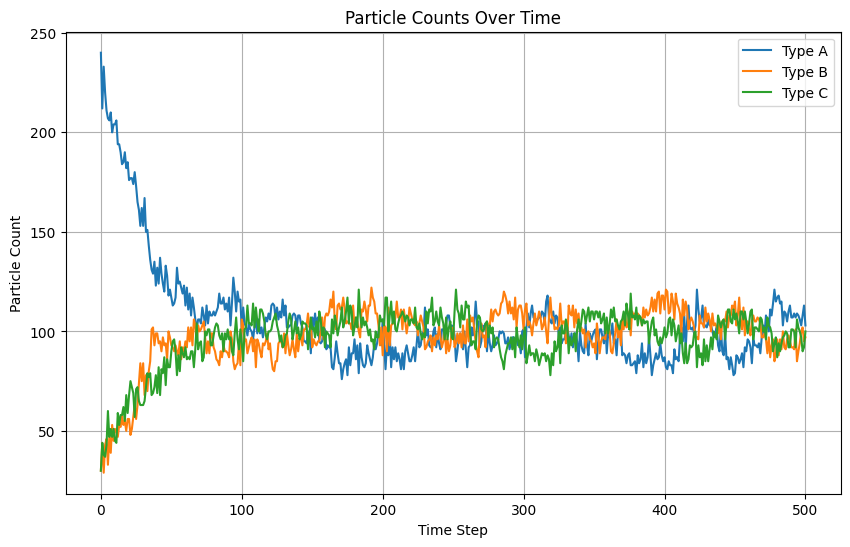

Initial particle counts: Counter({'A': 100, 'B': 100, 'C': 100})
Final particle counts: Counter({'A': 106, 'C': 100, 'B': 94})
Average counts: {'A': 100.1, 'B': 97.7, 'C': 102.2}
Standard deviations: {'A': 8.5693251387337, 'B': 8.538149682454625, 'C': 9.114091653404998}


In [250]:
# 即使radius小，导致他们在原来的基础上更难collides，但可以通过增加速度，stepsize来让他最终还是到达equilibrium
particles_info2 = {
    'A': (240, 0.01),  # A类型粒子，半径1
    'B': (30, 1),  # B类型粒子，半径1
    'C': (30, 1),  # C类型粒子，半径1
}

box_size = np.array([10, 10, 10])  # 盒子大小
velocity_scale = 30  # 速度比例系数
steps = 500  # 时间步数
dt = 0.1  # 时间步长
repeat_times = 10  # 重复实验次数
radius_map = {'A': 1, 'B': 3, 'C': 3}  # 假设半径大小

# 运行模拟并获取结果
results4a = run_simulation(particles_info2, box_size, velocity_scale, steps, dt, repeat_times,radius_map)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

Different radius


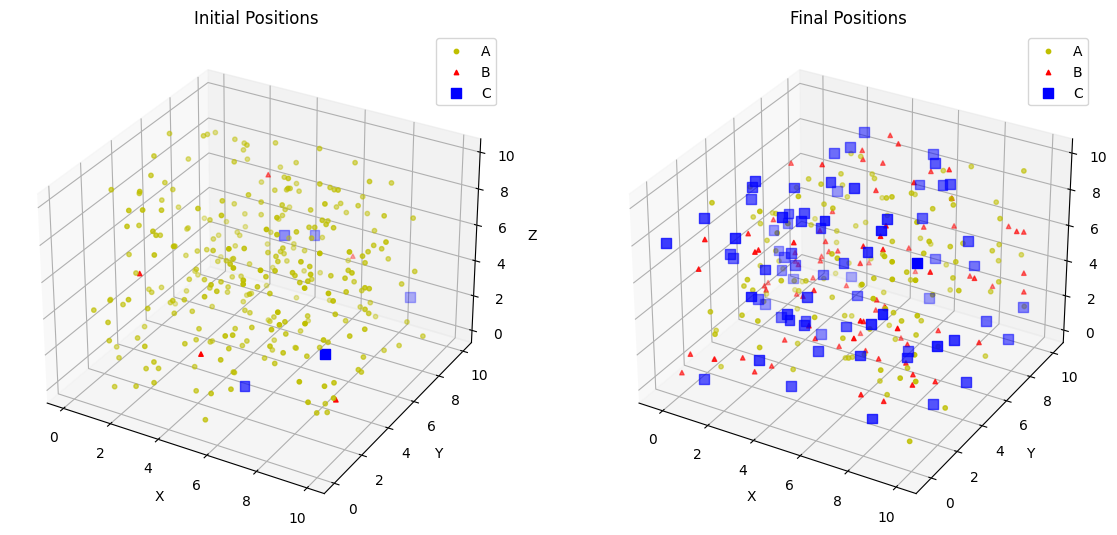

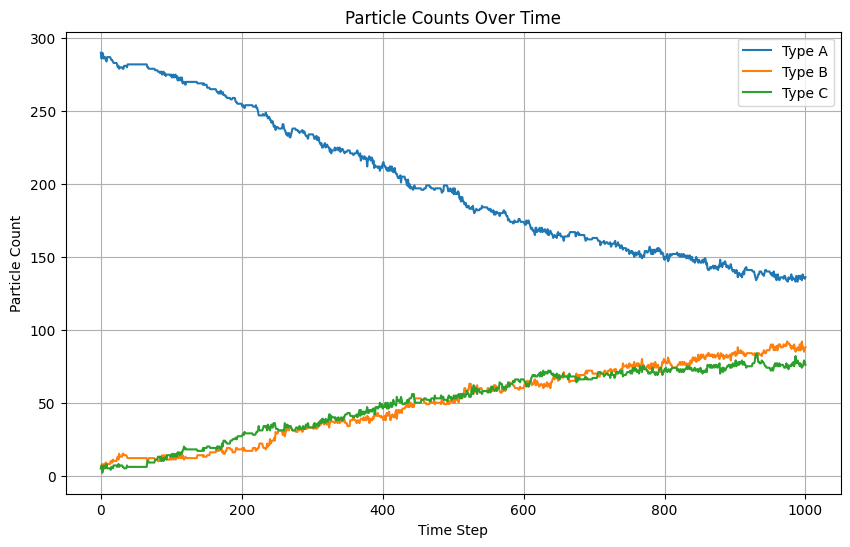

Initial particle counts: Counter({'A': 100, 'B': 100, 'C': 100})
Final particle counts: Counter({'A': 106, 'C': 100, 'B': 94})
Average counts: {'A': 100.1, 'B': 97.7, 'C': 102.2}
Standard deviations: {'A': 8.5693251387337, 'B': 8.538149682454625, 'C': 9.114091653404998}


In [258]:
# 即使radius小，导致他们在原来的基础上更难collides，但可以通过增加速度，stepsize来让他最终还是到达equilibrium
particles_info2 = {
    'A': (290, 0.01),  # A类型粒子，半径1
    'B': (5, 0.01),  # B类型粒子，半径1
    'C': (5, 1),  # C类型粒子，半径1
}

box_size = np.array([10, 10, 10])  # 盒子大小
velocity_scale = 30  # 速度比例系数
steps = 1000  # 时间步数
dt = 0.1  # 时间步长
repeat_times = 10  # 重复实验次数
radius_map = {'A': 1, 'B': 1, 'C': 5}  # 假设半径大小

# 运行模拟并获取结果
results4a = run_simulation(particles_info2, box_size, velocity_scale, steps, dt, repeat_times,radius_map)

# 打印结果
print("Initial particle counts:", results['initial_counts'])
print("Final particle counts:", results['final_counts'])
print("Average counts:", results['average_counts'])
print("Standard deviations:", results['stddev_counts'])

extension 1: disease spread

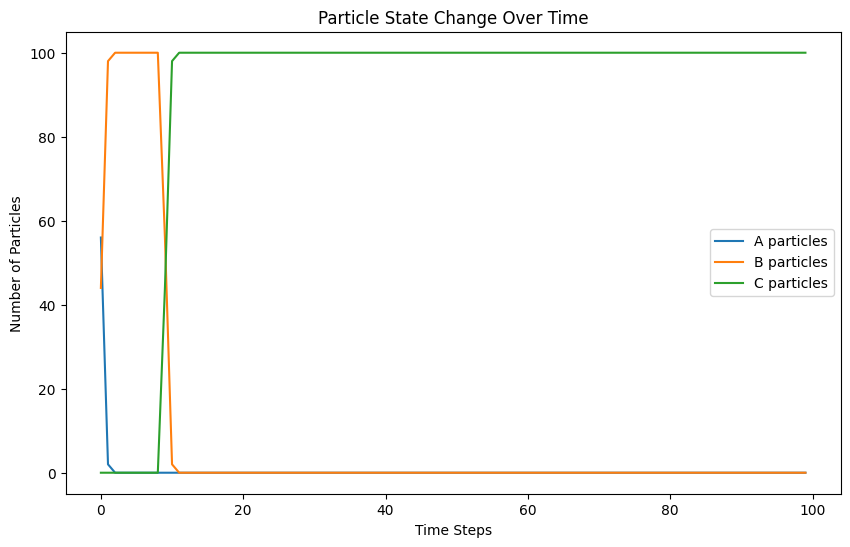

In [260]:
import numpy as np
import random
import matplotlib.pyplot as plt

class Particle:
    def __init__(self, particle_type):
        self.type = particle_type
        self.time_infected = 0

def update_particles(particles, infection_duration):
    for particle in particles:
        if particle.type == 'B':
            particle.time_infected += 1
            if particle.time_infected >= infection_duration:
                particle.type = 'C'

def simulate_infection(particles, infection_probability, infection_duration, steps):
    state_counts_over_time = {'A': [], 'B': [], 'C': []}  # Track counts over time

    for step in range(steps):
        # Simulate one time step
        for i in range(len(particles)):
            for j in range(i + 1, len(particles)):
                if particles[i].type == 'A' and particles[j].type == 'B' or particles[i].type == 'B' and particles[j].type == 'A':
                    if random.random() < infection_probability:
                        particles[i].type = 'B' if particles[i].type == 'A' else particles[i].type
                        particles[j].type = 'B' if particles[j].type == 'A' else particles[j].type
        update_particles(particles, infection_duration)

        # Count states after this time step
        counts = {'A': 0, 'B': 0, 'C': 0}
        for particle in particles:
            counts[particle.type] += 1
        for state, count in counts.items():
            state_counts_over_time[state].append(count)

    return state_counts_over_time

# Initialize particles
num_particles = 100
particles = [Particle('A') for _ in range(int(num_particles * 0.9))] + [Particle('B') for _ in range(int(num_particles * 0.1))]
state_counts_over_time = simulate_infection(particles, 0.05, 10, 100)

# Plotting
plt.figure(figsize=(10, 6))
for state, counts in state_counts_over_time.items():
    plt.plot(counts, label=f"{state} particles")

plt.xlabel("Time Steps")
plt.ylabel("Number of Particles")
plt.title("Particle State Change Over Time")
plt.legend()
plt.show()



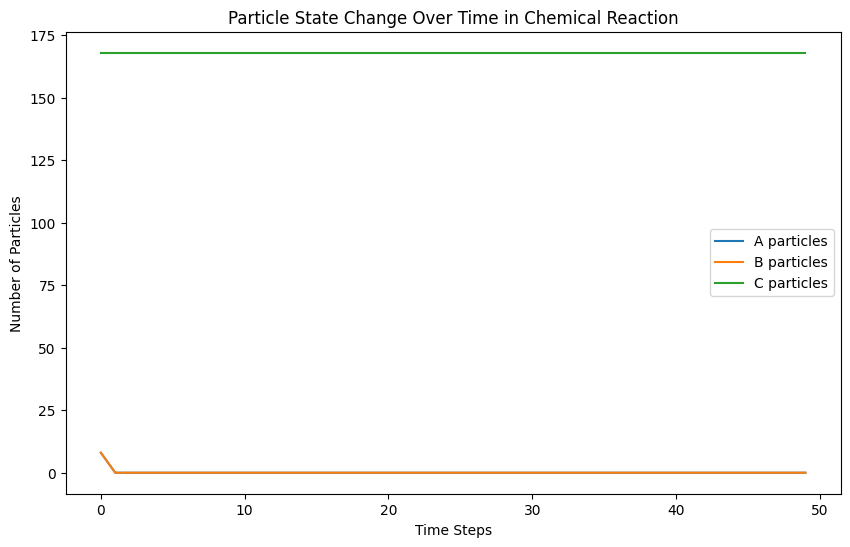

In [261]:
import numpy as np
import random
import matplotlib.pyplot as plt

class Particle:
    def __init__(self, particle_type):
        self.type = particle_type

def simulate_reaction(particles, reaction_probability, steps):
    state_counts_over_time = {'A': [], 'B': [], 'C': []}  # Track counts over time
    
    for step in range(steps):
        # Randomly pair particles for potential reaction
        for i in range(len(particles)):
            for j in range(i + 1, len(particles)):
                if particles[i].type == 'A' and particles[j].type == 'B':
                    # A collides with B, both become C with a certain probability
                    if random.random() < reaction_probability:
                        particles[i].type = 'C'
                        particles.append(Particle('C'))  # Add a new C particle
                        particles[j].type = 'C'
                        particles.append(Particle('C'))  # Add another new C particle

        # Count states after this time step
        counts = {'A': 0, 'B': 0, 'C': 0}
        for particle in particles:
            counts[particle.type] += 1
        for state, count in counts.items():
            state_counts_over_time[state].append(count)
        
        # Adjust the list to remove converted particles
        particles = [particle for particle in particles if particle.type == 'C']

    return state_counts_over_time

# Example usage
num_particles = 100
reaction_probability = 0.05  # Probability of reaction upon collision
steps = 50  # Total simulation steps

# Initialize particles
particles = [Particle('A') for _ in range(int(num_particles * 0.5))] + \
            [Particle('B') for _ in range(int(num_particles * 0.5))]

state_counts_over_time = simulate_reaction(particles, reaction_probability, steps)

# Plotting
plt.figure(figsize=(10, 6))
for state, counts in state_counts_over_time.items():
    plt.plot(counts, label=f"{state} particles")

plt.xlabel("Time Steps")
plt.ylabel("Number of Particles")
plt.title("Particle State Change Over Time in Chemical Reaction")
plt.legend()
plt.show()
